In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN

import os

In [6]:
# Load and preprocess data
cwd = os.getcwd()
cwd = '/'.join(cwd.split('/')[:-1])


file_path = 'C:/Users/rishe/Buy-vs-Rent/Datasets/observed_rent_index_co.pkl'
region = 'Boulder'
df = pd.read_pickle(file_path)

In [7]:
# Filter for the specific region
df_region = df[df['RegionName'] == region].copy()
df_region = df_region.reset_index(drop=True)

# Extract the observed_rent_index list
rent_index = df_region['observed_rent_index'].iloc[0]

In [8]:
df_region = pd.DataFrame({
    'ds': pd.date_range(start='2015-01-31', periods=len(rent_index), freq='M'),
    'y': rent_index
})

C:\Users\rishe\AppData\Local\Temp\ipykernel_60828\1041842770.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  'ds': pd.date_range(start='2015-01-31', periods=len(rent_index), freq='M'),


In [9]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
df_region['y_scaled'] = scaler.fit_transform(df_region[['y']])

# Prepare data for neural network
look_back = 12
data = df_region['y_scaled'].values

X, y = [], []
for i in range(len(data) - look_back):
    X.append(data[i:i + look_back])
    y.append(data[i + look_back])
X, y = np.array(X), np.array(y)

In [10]:
# Split into training and testing datasets
train_size = len(df_region[df_region['ds'] < '2023-01-01'])
X_train, y_train = X[:train_size - look_back], y[:train_size - look_back]
X_test, y_test = X[train_size - look_back:], y[train_size - look_back:]

# Reshape data for RNN
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Build and train the RNN model
model = Sequential()
model.add(SimpleRNN(50, return_sequences=True, input_shape=(look_back, 1)))
model.add(SimpleRNN(50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train, y_train, epochs=500, batch_size=32, verbose=1)

Epoch 1/500


c:\Users\rishe\anaconda3\envs\py311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.4056
Epoch 2/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1735 
Epoch 3/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0222 
Epoch 4/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0457 
Epoch 5/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0205 
Epoch 6/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0159 
Epoch 7/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0233 
Epoch 8/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0037 
Epoch 9/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0117 
Epoch 10/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0060 
Epoch 11/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0052 
Epoch 12/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0067 
Epoch 13/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0026 
Epoch 14/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0043 
Epoch 15/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - loss: 0.0028  
Epoch 16/500
3/3 ━━━━━━━━━━━━━━━

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


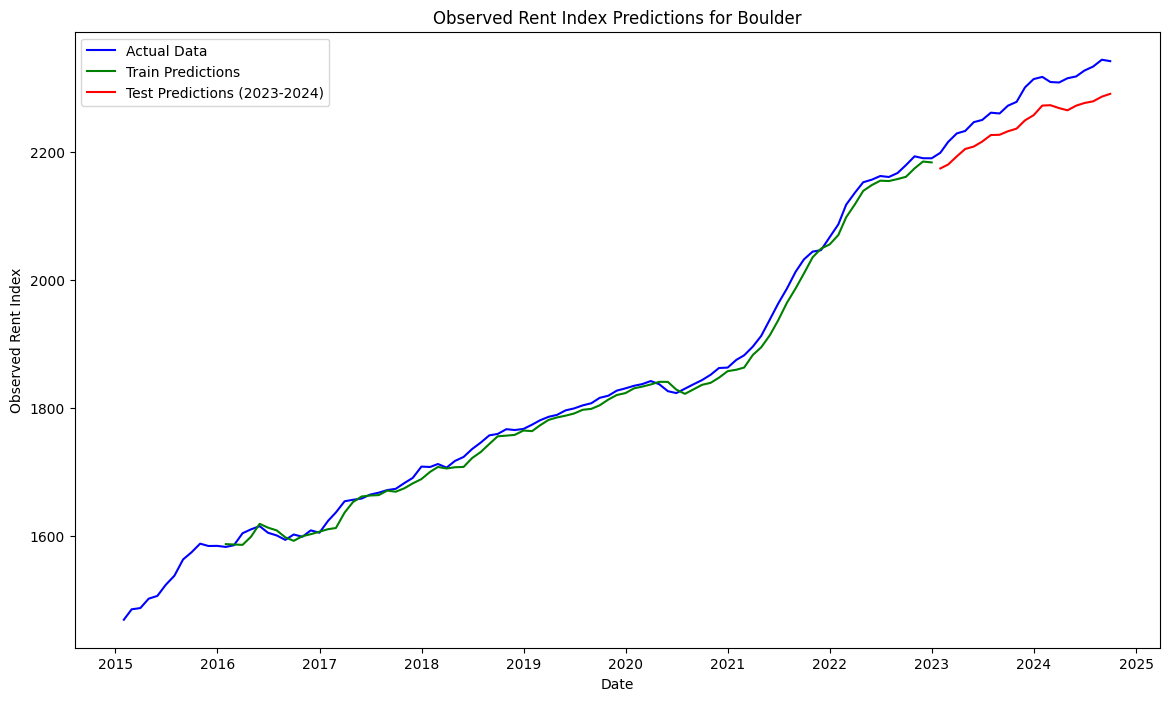

In [11]:
# Predict and inverse transform
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

train_predictions = scaler.inverse_transform(train_predictions)
test_predictions = scaler.inverse_transform(test_predictions)

# Create predictions DataFrame for visualization
train_dates = df_region['ds'][look_back:train_size]
test_dates = df_region['ds'][train_size:]

# Plot the results
plt.figure(figsize=(14, 8))
plt.plot(df_region['ds'], df_region['y'], label='Actual Data', color='blue')  # All actual data
plt.plot(train_dates, train_predictions, label='Train Predictions', color='green')
plt.plot(test_dates, test_predictions, label='Test Predictions (2023-2024)', color='red')
plt.xlabel('Date')
plt.ylabel('Observed Rent Index')
plt.title(f'Observed Rent Index Predictions for {region}')
plt.legend()
plt.show()

In [12]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Actual values for testing
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Compute Accuracy Metrics
mae = mean_absolute_error(y_test_actual, test_predictions)
rmse = sqrt(mean_squared_error(y_test_actual, test_predictions))
mape = np.mean(np.abs((y_test_actual - test_predictions) / y_test_actual)) * 100

# Print the results
print("\nAccuracy Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")



Accuracy Metrics:
Mean Absolute Error (MAE): 42.08
Root Mean Squared Error (RMSE): 43.07
Mean Absolute Percentage Error (MAPE): 1.84%
